In [1]:
import json
import os
import glob
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

import numpy as np
from collections import Counter, defaultdict
import random
import math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))

john11
scr1


In [2]:
DISK_IO_DIR = "/{}/scr1/yiweil".format(machine_name)
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)

/john11/scr1/yiweil


In [3]:
og_dir = '/juice/scr/yiweil/Green-American-Lexicon/2_data_exploration'
os.chdir('../1_data_collection/reddit/convokit')
from customized_fighting_words import FightingWords
os.chdir(og_dir)

# Load ConvoKit corpus

In [4]:
from convokit import Corpus, Speaker
corpus = Corpus(
    filename='/u/scr/yiweil/my-cmv-corpus_1-1-2010_to_09-24-2021')
corpus.print_summary_stats()

Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


In [154]:
# maintain list of generic comments, e.g. "[deleted]", "[removed]" to filter
UTT_THRESHOLD = 50
all_utterance_texts = [
    utt.text[:UTT_THRESHOLD] for utt in corpus.iter_utterances()
]
counted_utts = Counter(all_utterance_texts)
del all_utterance_texts
top_generic_comments = sorted(counted_utts.items(), key = lambda x: x[1], reverse=True)[:40]
top_generic_prefixes = [item[0][:30].lower() for item in top_generic_comments]
del top_generic_comments
to_keep = {'agreed','do you think people have an ob','exactly.','fair enough.','how so?','how?',
          'i agree.','source?','thank you.','thanks!','what?','why?','yes','yes.','∆','','.'}
top_generic_prefixes = set(top_generic_prefixes).difference(to_keep)

# filter out bots
bots = pickle.load(open('../1_data_collection/reddit/bots/bots.pkl','rb'))

In [165]:
top_generic_prefixes

{'!delta',
 '**note:** your thread has **no',
 '1',
 '[deleted]',
 '[removed]',
 'agreed.',
 'confirmed: 1 delta awarded to ',
 "i'm a bot, *bleep*, *bloop*. s",
 'no',
 'no.',
 'removed, see comment rule 1.',
 'thank you!',
 'the moderators have confirmed ',
 'this award is currently disall',
 'this comment has been overwrit',
 'this delta has been rejected. ',
 'this delta is currently disall',
 'what do you mean?',
 'why not?',
 'you cannot award op a delta as',
 'your submission has been autom'}

In [85]:
speaker_names = [corpus.get_speaker(s_id).id for s_id in speaker_ids]

In [91]:
potential_bots = [x for x in speaker_names if type(x) == str and 'bot' in x and 'robot' not in x.lower()
and 'bottle' not in x.lower() and 'bottom' not in x.lower()]

In [155]:
# known_mods = [
#     'hacksoncode',
#     'DeltaBot',
#     'cwenham',
#     'FlyingFoxOfTheYard_',
#     'wyantb',
#     'MystK',
#     'AutoModerator',
#     'Ansuz07'
# ]

# with open('../1_data_collection/reddit/known_cmv_mods.txt','w') as f:
#     for mod in known_mods:
#         f.write(mod+'\n')
        
# Known moderators of r/changemyview listed at: 
# https://www.reddit.com/r/DeltaLog/about/moderators/
with open('../1_data_collection/reddit/known_cmv_mods.txt','r') as f:
    known_cmv_mods = f.read().splitlines()
    
bots = bots | set(known_cmv_mods)

In [477]:
import re
def contains_keyword(s,keyword_set,verbose=False):
    pat = re.compile(r'\b(' + (r'|'.join([kw.replace('*','\*') for kw in keyword_set])) + r')\b')
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    res = set(pat.findall(s)).intersection(keyword_set)
    if verbose:
        return res
    return len(res) > 0

def has_generic_utterance_text(utt_idx,generic_spans=top_generic_prefixes):
    return contains_keyword(corpus.get_utterance(utt_idx).text,generic_spans)

def written_by_bot(utt_idx,bot_set=bots):
    return corpus.get_utterance(utt_idx).speaker.id in bot_set

In [157]:
# Update meta to include whether an utterance is generic
# and whether it was written by a likely bot
for utt in corpus.iter_utterances():
    utt.meta['is_generic'] = has_generic_utterance_text(utt.id)
    utt.meta['written_by_bot'] = written_by_bot(utt.id)

In [159]:
# Retrieve authors of generic comments as a way of filtering out bots/moderators
generic_authors = [
    utt.speaker.id for utt in corpus.iter_utterances()
    if utt.meta['is_generic']
]

In [161]:
#Counter(generic_authors)

In [164]:
# print('Number of bots/mods pre-generic comment authors:',len(bots))
# bots = bots | set(generic_authors)
# print('Number of bots/mods post-generic comment authors:',len(bots))

Number of bots/mods pre-generic comment authors: 2812
Number of bots/mods post-generic comment authors: 44677


In [12]:
# for utt in corpus.iter_utterances():
#     utt.meta['written_by_bot'] = written_by_bot(utt.id)

In [232]:
def cleanup(utt_text):
    lines = [line for line in utt_text.splitlines()
             if not line.lstrip().startswith("&gt;")
             and not line.lstrip().startswith("____")
             and "edit" not in " ".join(line.lower().split()[:2])
            ]
    return "\n".join(lines)

In [234]:
#cleanup(utt.text)

In [309]:
utt_ids_to_keep = [utt.id for utt in corpus.iter_utterances()
                  if not utt.meta['written_by_bot']
                  and not utt.meta['is_generic']
                  and not utt.text == '[deleted]'
                  and not utt.text == '[removed]']
print("Doing all analysis restricted to {} non-generic utterances not written by a bot or moderator.".format(
    len(utt_ids_to_keep)))

Doing all analysis restricted to 2710416 non-generic utterances not written by a bot or moderator.


# Find climate-change related conversations

In [167]:
import re
def remove_special_chars(s):
    return re.sub('[^A-Za-z]+', ' ', s)

def contains_keyword(s,keyword_set,ignore_case=True):
    if ignore_case:
        s = s.lower()
    pat = re.compile(r'\b(' + (r'|'.join(keyword_set)) + r')\b')
    #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
    return len(set(pat.findall(s)).intersection(keyword_set)) > 0

with open('../1_data_collection/keywords_high_precision.txt','r') as f:
    CLIMATE_KEYWORDS = f.read().splitlines()
#print(CLIMATE_KEYWORDS)

In [168]:
def get_op(convo_idx):
    return corpus.get_utterance(convo_idx)

def get_op_title(op):
    return op.meta['title']

def get_op_text(op):
    return op.text

In [169]:
climate_convo_idxs = []
for convo in tqdm(corpus.iter_conversations()):
    op_idx = convo.id
    op = get_op(op_idx)
    op_title = get_op_title(op)
    if contains_keyword(op_title, set(CLIMATE_KEYWORDS)):
        climate_convo_idxs.append(op_idx)
len(climate_convo_idxs)

84258it [00:02, 31669.81it/s]


637

In [170]:
# Add meta field for whether utterance belongs to climate change-related conversation
for utt in tqdm(corpus.iter_utterances()):
    utt.meta['is_cc_related'] = utt.conversation_id in \
                                set(climate_convo_idxs)

In [171]:
#convo.print_conversation_structure(lambda utt: utt.text[:80])

# Stance labeling

In [71]:
# Select random sample to manually classify
sample_convo_ids = np.random.choice(climate_convo_idxs,size=150,replace=False)
len(sample_convo_ids),sample_convo_ids[:3]

(150, array(['t3_an59pr', 't3_563ep2', 't3_2ylc5a'], dtype='<U9'))

In [83]:
# Write to file to manually label
pd.DataFrame({
    'id': sample_convo_ids,
    'title': [corpus.get_utterance(convo_id).meta['title'] 
             if 'title' in corpus.get_utterance(convo_id).meta else -1
             for convo_id in sample_convo_ids],
    'label': [-1]*len(sample_convo_ids)
}).to_csv('cmv_climate_posts_to_manually_stance_label.csv',header=True,index=False)

In [57]:
# Read in labels
sample_with_labels_df = pd.read_csv('/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/\
cmv_climate_posts_with_manual_stance_labels.csv',header=0)
sample_with_labels_df.head()

,id,title,label
0,t3_an59pr,CMV: The most ethical course of action is to take very drastic measures to stop climate change,p
1,t3_563ep2,CMV: I will not have kids due to climate change.,ps
2,t3_2ylc5a,CMV:Climate change is a scam by the UN,a
3,t3_ehwa7r,Politicians who don't believe in climate change should not be allowed to hold public office,ps
4,t3_bg5fnj,CMV: Patanogia donating $10 Million towards climate change sets a bad precedent.,an


In [58]:
# Aggregate fine-grained annotations into one of 3 macro categories
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['label'].apply(lambda x: x[0])
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['manual_label_macro'].apply(
    lambda x: {'p':'pro',
               'a':'anti',
               'n':'neutral'}[x] if x in {'p','a','n'} else x)
sample_with_labels_df['manual_label_macro'].value_counts()

pro        92
anti       38
neutral    20
Name: manual_label_macro, dtype: int64

In [62]:
sample_with_labels_df['label'].value_counts()/sum(sample_with_labels_df['label'].value_counts())

ps    0.380000
a     0.246667
p     0.126667
n     0.126667
pa    0.106667
an    0.006667
na    0.006667
Name: label, dtype: float64

In [59]:
# Plot distribution over time
# x-axis: time
# y-axis: conversation stance

from datetime import datetime
def get_convo_time(convo_id):
    return corpus.get_utterance(convo_id).meta['created']

sample_with_labels_df['time'] = sample_with_labels_df['id'].apply(lambda x: get_convo_time(x))
sample_with_labels_df['year'] = sample_with_labels_df['time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

sns.displot(data=sample_with_labels_df,x='year',hue='manual_label_macro',ax=ax,multiple='stack')
plt.xlabel('')
plt.ylabel('Number of posts')
plt.title('Stance of post titles over time')
sns.despine()
plt.legend(title='Stance of post title', loc='upper left', labels=['neutral', 'anti', 'pro'])

NameError: name 'ax' is not defined

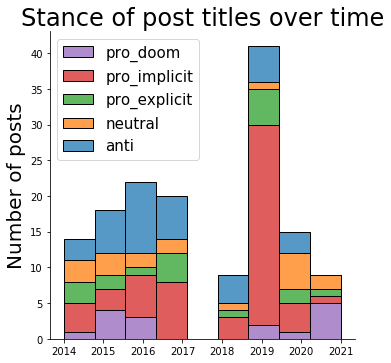

In [63]:
plt.rcParams['figure.figsize'] = [10, 14]
sns.displot(data=sample_with_labels_df.loc[sample_with_labels_df['label']
                                          .isin({'p','ps','pa','a','n'})],x='year',hue='label',multiple='stack',
           hue_order=['a','n','p','ps','pa'],legend=False)
plt.xlabel('')
plt.ylabel('Number of posts',fontsize=20)
plt.title('Stance of post titles over time',fontsize=24)
sns.despine()
plt.legend(title='', loc='upper left', labels=['anti', 'neutral', 'pro_explicit', 'pro_implicit',
                                                                  'pro_doom'][::-1],
          fontsize=15)
plt.savefig('figs/stance_manual_labels_over_time.png',dpi=200,bbox_inches="tight")

# Features

## Arousal

In [ ]:
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/') 

result = senti.getSentiment('What a lovely day', score='dual')
print(result)

def get_senti_scores(utts, senti_model, score='dual'):
    """
    param s: str to label for arousal
    param senti_model: instance of a PySentiStr() object
    param score: 'unary', 'dual' (default), 'binary', or 'ternary'
    """
    res = senti_model.getSentiment(utts, score=score)
    return res

# utt_ids = corpus.get_utterance_ids()
# all_senti_scores = []

# for ix in range(0,len(utt_ids),1000):
#     utt_ids_batch = utt_ids[ix:min(ix+1000,len(utt_ids))]
#     utts_batch = [corpus.get_utterance(utt_id) 
#                  for utt_id in utt_ids_batch]
#     utts_batch_senti_scores = get_senti_scores([utt.text for utt in 
#                                     utts_batch], senti)
#     all_senti_scores.extend(list(zip(utt_ids_batch,utts_batch_senti_scores)))
#     if ix % 1000 == 0:
#         print(ix)

senti_scores = pickle.load(open('all_senti_scores.pkl','rb'))
utt_id2senti_score = dict(zip([item[0] for item in senti_scores],
                              [item[1] for item in senti_scores]))

def assign_senti_cat(senti_res): 
    res_pos, res_neg = senti_res[0], senti_res[1]
    if res_pos == 2:
        return 'lo_pos'
    elif res_pos > 2:
        return 'hi_pos'
    elif res_neg == -2:
        return 'lo_neg'
    elif res_neg < -2:
        return 'hi_neg'
    elif res_pos == 1 and res_neg == -1:
        return 'neut'
    else:
        print("Could not fit sentence within labeling scheme:", 
              senti_res)
        
for utt in tqdm(subsample.iter_utterances()):
    utt.meta['senti_arousal_cat'] = assign_senti_cat(utt_id2senti_score[utt.id])

## People

In [ ]:
NE_stance_dict = pd.read_pickle('/u/scr/yiweil/GWStance/4_analyses/NE_stance_dict.pkl')
NE_fuzzy_map = pd.read_pickle('/u/scr/yiweil/GWStance/4_analyses/named_entity_fuzzymatch_map.pkl')
people_set = set([re.sub('[^A-Za-z0-9]+', ' ', x) for x in NE_fuzzy_map.keys()])
len(people_set)

PEOPLE = set([
    'greta thunberg',
    'al gore',
    'donald trump'
    'joe biden',
    ''
])

In [ ]:
def has_person(utt,people_set,verbose=False):
    clean_utt = re.sub('[^A-Za-z0-9]+', ' ', utt)
    return contains_keyword(utt,people_set,verbose=verbose)

for utt in tqdm(subsample.iter_utterances()):
    utt.meta['entities_in_text'] = has_person(utt.text,people_set,verbose=True)

112734it [1:34:03, 17.78it/s]

In [ ]:
utts_with_people = [utt.id for utt in subsample.iter_utterances()
if utt.meta['entities_in_text']]

In [ ]:
subsample.get_utterance(utts_with_people[0]).text

## DeSMOG features

In [ ]:
desmog_feats_dict = defaultdict(list)
for fname in glob.glob('/u/scr/yiweil/GWStance/4_analyses/lexicons/*.txt'):
    feats_cat = fname.split('/')[-1].split('.txt')[0]
    with open(fname,'r') as f:
        desmog_feats_dict[feats_cat].extend(f.read().splitlines())

# Engagement

In [329]:
non_cc_ids_to_keep = [utt_id for utt_id in utt_ids_to_keep
                     if not subsample.get_utterance(utt_id).meta['is_cc_related']]
cc_ids_to_keep = set(utt_ids_to_keep).difference(set(non_cc_ids_to_keep))
random_sample_size = 5000
print("Drawing random sample of {} from {} non-climate comments for plotting efficiency.".format(
    random_sample_size,len(non_cc_ids_to_keep)))
random_non_cc_ids_to_plot = list(np.random.choice(utt_ids_to_keep,size=random_sample_size,replace=False))
random_ids_to_plot = random_non_cc_ids_to_plot + list(cc_ids_to_keep)
print("Final size of random sample of climate-related and non-climate comments:",len(random_ids_to_plot))

Drawing random sample of 5000 from 681619 non-climate comments for plotting efficiency.
Final size of random sample of climate-related and non-climate comments: 10573


In [330]:
len(cc_ids_to_keep)

5573

In [ ]:
len(utt_ids_to_keep)

## Relationship/distribution of engagement variables

In [359]:
del eng_df
utt_eng_zip = list(zip([subsample.get_utterance(utt_id).meta['score'] for utt_id in utt_ids_to_keep],
                       [subsample.get_utterance(utt_id).meta['ups'] for utt_id in random_ids_to_plot],
                       [subsample.get_utterance(utt_id).meta['downs'] for utt_id in random_ids_to_plot],
                       [subsample.get_utterance(utt_id).meta['is_awarded_delta'] for utt_id in random_ids_to_plot],
                       [subsample.get_utterance(utt_id).meta['is_cc_related'] for utt_id in random_ids_to_plot]))

eng_df = pd.DataFrame({
    'score':[item[0] for item in utt_eng_zip],
    #'log_score':[np.log(item[0]+1) for item in utt_zip],
    'ups':[item[1] for item in utt_eng_zip],
    'log_ups':[np.log(item[1]+1) for item in utt_eng_zip],
    'downs':[item[2] for item in utt_eng_zip],
    'log_downs':[np.log(item[2]+1) for item in utt_eng_zip],
    'upvote_ratio':[item[1]/(item[2]+.1) for item in utt_eng_zip],
    'is_awarded_delta':[item[3] for item in utt_eng_zip],
    'is_cc_related':[item[4] for item in utt_eng_zip]
})

eng_df.describe()

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


,score,ups,log_ups,downs,log_downs,upvote_ratio
count,10573.000000,10573.000000,1.047100e+04,10573.0,10573.0,10573.000000
mean,5.556796,5.556796,-inf,0.0,0.0,55.567956
std,27.788389,27.788389,NaN,0.0,0.0,277.883894
min,-19.000000,-19.000000,-inf,0.0,0.0,-190.000000
25%,1.000000,1.000000,6.931472e-01,0.0,0.0,10.000000
50%,2.000000,2.000000,1.098612e+00,0.0,0.0,20.000000
75%,4.000000,4.000000,1.609438e+00,0.0,0.0,40.000000
max,1797.000000,1797.000000,7.494430e+00,0.0,0.0,17970.000000


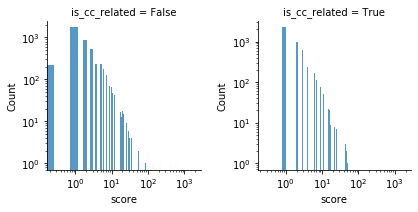

In [340]:
g = sns.FacetGrid(eng_df, col="is_cc_related", sharey=False)#, aspect=1.5)
g.map(sns.histplot, "score")
g.set(xscale="log", yscale="log")

## Correlation of engagement with features of interest: arousal, NEs

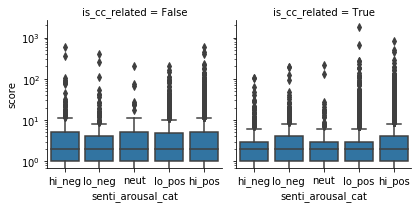

In [392]:
eng_df['senti_arousal_cat'] = [subsample.get_utterance(utt_id).meta['senti_arousal_cat']
                              for utt_id in random_ids_to_plot]
g = sns.FacetGrid(eng_df, col = 'is_cc_related')
g.map(sns.boxplot, 'senti_arousal_cat', 'score', showfliers=True,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")

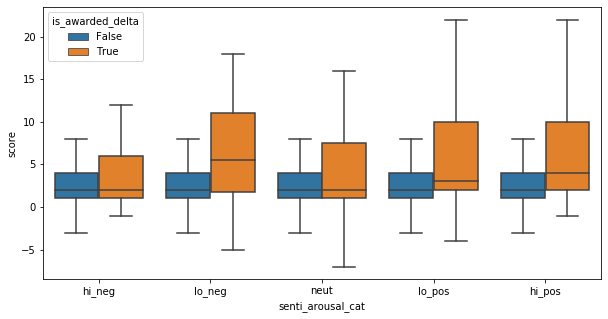

In [366]:
sns.boxplot(data=eng_df, x='senti_arousal_cat', y='score', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
           hue='is_awarded_delta')

In [ ]:
# Does score differ for comments w/ and w/o people?

eng_df['has_person'] = [len(subsample.get_utterance(utt_id).meta['entities_in_text']) > 0
                              for utt_id in random_ids_to_plot]

g = sns.FacetGrid(eng_df, col = 'is_cc_related')
g.map(sns.boxplot, 'has_person', 'score', showfliers=True)
g.set(yscale="log")

In [ ]:
# Add deltas into the picture
sns.boxplot(data=eng_df, x='has_person', y='score', showfliers=False,
           hue='is_awarded_delta')

# Comments receiving deltas vs. not

Maintain list of comments awarded deltas by:

iterating through all comment utterances

if: speaker.isin(known_mods) AND comment begins with a CUE_START
    
    save: id of mod comment, 
    comment awarding the delta (mod comment's reply_to parent),
    comment awarded the delta (comment awarding the delta's reply_to)

In [111]:
# CUE_STARTS = {'Confirmed: 1 delta awarded to /u/',
#              'Confirmed - 1 delta awarded to /u/',
#              'The moderators have confirmed, ei'}

# with open(os.path.join(DISK_IO_DIR,'deltalog.tsv'),'w') as f:
#     f.write('{}\t{}\t{}\n'.format('logging_utt_id','awarding_utt_id',
#                                   'awarded_utt_id'))
#     for utterance in tqdm(corpus.iter_utterances()):
#         if utterance.speaker.id in known_cmv_mods\
#         and (utterance.text.startswith('Confirmed: 1 delta awarded to /u/')\
#              or utterance.text.startswith('Confirmed - 1 delta awarded to /u/')\
#              or utterance.text.startswith('The moderators have confirmed, ei')):
#             logging_comment_id = utterance.id
#             awarding_comment_id = utterance.reply_to
#             awarded_comment_id = corpus.get_utterance(awarding_comment_id)\
#                                         .reply_to
#             f.write('{}\t{}\t{}\n'.format(
#                 logging_comment_id,awarding_comment_id,
#                     awarded_comment_id))

deltalog = pd.read_csv(os.path.join(DISK_IO_DIR,'deltalog.tsv'),
                      sep='\t',header=0)
delta_awarded_utt_ids = set(deltalog['awarded_utt_id'].values)

# Update meta to include whether an utterance was awarded a delta or not
def is_awarded_delta(utterance_id):
    return utterance_id in delta_awarded_utt_ids

for utt in tqdm(corpus.iter_utterances()):
    utt.meta['is_awarded_delta'] = is_awarded_delta(utt.id)

3243830it [00:06, 472057.68it/s]


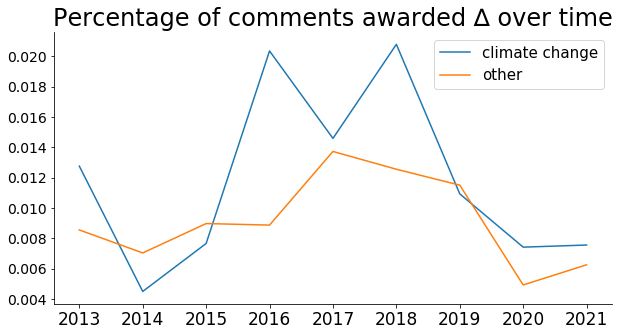

In [225]:
# counts_by_bin = defaultdict(lambda: defaultdict(int))

# for utt in tqdm(corpus.iter_utterances()):
#     if not utt.meta['written_by_bot']\
#     and utt.timestamp:
#         year = datetime.utcfromtimestamp(utt.timestamp).year
#         if utt.meta['is_cc_related']:
#             if utt.meta['is_awarded_delta']:
#                 counts_by_bin[year]['cc_delta'] += 1
#             else:
#                 counts_by_bin[year]['cc_no_delta'] += 1
#         else:
#             if utt.meta['is_awarded_delta']:
#                 counts_by_bin[year]['non_cc_delta'] += 1
#             else:
#                 counts_by_bin[year]['non_cc_no_delta'] += 1
# print(counts_by_bin)

# for year in counts_by_bin:
#     for key in counts_by_bin[year]:
#         print('year:',year)
#         print(key,counts_by_bin[year][key])

years = list(range(2013,2022))
topics = ['climate change','other']
classes = ['awarded delta','not awarded delta']
to_plot_df = pd.DataFrame({
    'year':[item for sublist in 
            [[y]*len(topics)*len(classes) for y in years]
            for item in sublist],
    'topic':[item for sublist in 
            [[t]*len(classes) for t in topics]
            for item in sublist]*len(years),
    'class':classes*len(years)*len(topics),
    'count':[6,464,465,53873,16,3539,2795,394208,19,2460,3494,385645,
            56,2694,3309,369436,43,2903,5193,372894,38,1789,4574,359555,
            61,5516,4010,344344,32,4279,1751,353511,37,4856,2938,466541]
})

per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
to_plot_df['percent'] = to_plot_df.apply(
    lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
                        .loc[x['topic']]['count'],
    axis=1
)

plt.rcParams['figure.figsize'] = [10, 5]
sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='awarded delta'],
           x='year',y='percent',hue='topic')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=17)
plt.yticks(fontsize=14)
plt.title('Percentage of comments awarded ∆ over time',fontsize=24)
plt.legend(title='',fontsize=15)
sns.despine()
plt.savefig('figs/pct_comments_awarded_delta_over_time.png',
            dpi=200,bbox_inches="tight")

Examples of comments awarding deltas, which explain why user was persuaded:

In [289]:
comments_awarding_deltas_climate_threads = [
    utt_id for utt_id in deltalog['awarding_utt_id'].values
    if corpus.get_utterance(utt_id).meta['is_cc_related']
]
print(len(comments_awarding_deltas_climate_threads))

pd.DataFrame({
    'id':comments_awarding_deltas_climate_threads,
    'text':[corpus.get_utterance(utt_id).text
           for utt_id in comments_awarding_deltas_climate_threads]
})

319


,id,text
0,t1_ef9tzs5,∆ Yeah that's honestly a solid point it would be nice if the government could just handle it. So another solution would bne if we could just stop being so over hyped about the issue in general.\n\nOnly issue is that I think we are in way too deep for that to work. It is at the forefront of public policy right now. Plus the changes that liberals are proposing would cost trillions of dollars and have huge impact on peoples lives....which leads to yellow vests.
1,t1_h8xaroo,[deleted]
2,t1_ejjs8tf,"Your point about diminishing returns on greenhouse gas emissions (because of common infrastructure) is a good one. Indeed, I had been imagining that Western population growth leads to emissions growth in a linear fashion. So I guess I'll give you a !delta for that.\n\nHowever, I still maintain my main view that having children isn't a good solution to climate change, on account of the fact that scientific engagement in western countries just isn't high enough. Most people are not involved in energy innovation and research, which means they're producing carbon emissions without contributing to the betterment of these technologies. Maybe if my country (USA) funded its schools better and made more of a conscious drive to shift the labor force towards energy research, then I'd feel differently about this.\n\nAlso, I think that the concept of diminishing returns could apply to energy innovation as well."
3,t1_fhqpeoe,"Yes, and they have links! I love it! \n\nKeep on sciencing, good sir!\n\n!delta"
4,t1_hb50dh3,"Δ I'll buy that. Bonus points for providing why, if fixed, it would be part of the solution to other issues too. Honestly it's the worst part of any kind of activism is battling with peoples lack of awareness. Pair with apathy it's probably the most immediate threat to humanity"
...,...,...
314,t1_ds5kees,[deleted]
315,t1_dh56ffl,∆ Thank you these articles did a great job of changing my view! This gets me thinking. Do humans have a right to keep reproducing and expanding even though that conflicts with general biological conservation? And how can we regulate that conflict?
316,t1_dcsvdvw,"∆ You know, you are right, it is definitely a case of the Dunning-Kruger effect, we just don't know how much we don't know. And I should recognize it as such, also, in the same way some people are hyperbolic negative, being hyperbolic positive is not wise, I recognize now my mistake."
317,t1_et321b6,"!delta\n\nIndividual lifestyle choices may not be useful on their own, but they can inspire others to demand change."


In [376]:
#deltalog.loc[deltalog['awarded_utt_id']==utt.id]

In [ ]:
#corpus.get_utterance('t1_gzcdegz').reply_to

In [ ]:
#corpus.get_utterance('t1_gzcdegz').text

In [ ]:
#utt.text

## Which features matter in changing people's minds?

List of features:
* engagement-related features
    * people/messengers
    * +/- arousal (based on SentiStrength)
    * EmoLex
* OG CMV paper features
    * non-textual features
        * entry time
        * len of back-and-forth
        * number of participants
    * textual features
        * interplay-related features
        * word category-based features
        * word score-based features
        * entire argument features
        * markdown formatting features
* DeSMOG features
    
    
NB: OG CMV paper uses different set-up to test importance of features by finding unsuccessful argument with highest Jaccard similarity to successful argument comment and training classifier to make binary prediction as to which one was successful. Intuition: control for content.

### Use subsample to control for length, depth, etc. across +delta and -delta samples

In [314]:
del corpus
subsample = Corpus(
    filename='/u/scr/yiweil/subsampled_cmv_corpus_general')
subsample.print_summary_stats()

Number of Speakers: 85342
Number of Utterances: 763067
Number of Conversations: 51139


In [316]:
utt_ids_to_keep = [utt.id for utt in subsample.iter_utterances()
                  if not utt.meta['written_by_bot']
                  and not utt.meta['is_generic']
                  and not utt.text == '[deleted]'
                  and not utt.text == '[removed]']
print("Doing all comparison analyses restricted to {} non-generic utterances \
from subsample not written by a bot or moderator.".format(
    len(utt_ids_to_keep)))

Doing all comparison analyses restricted to 687192 non-generic utterances from subsample not written by a bot or moderator.


### Climate change utterances too sparse--first use all CMV

###### RQ1: Is there a messenger effect for changing people's minds?

--> Are comments with deltas more likely to have people/named entities 
compared to comments not receiving deltas?

--> Do people/named entities tend to have large, positive LOR values?

--> Calculate LOR values for all people/named entities and look at their distributions--tend to skew positive?

In [388]:
fw_all_topics_no_bots = FightingWords()
fw_all_topics_no_bots.fit(subsample, 
        class1_func = lambda utt: (utt.meta['is_awarded_delta'])\
           and (not utt.meta['written_by_bot'])\
           and (not utt.meta['is_generic'])\
           and (not utt.text == '[deleted]')\
           and (not utt.text == '[removed]'),
        class2_func = lambda utt: (not utt.meta['is_awarded_delta'])\
           and (not utt.meta['written_by_bot'])\
           and (not utt.meta['is_generic'])\
           and (not utt.text == '[deleted]')\
           and (not utt.text == '[removed]'))

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 27513 valid corpus components. class2_func returned 659679 valid corpus components.


KeyboardInterrupt: 

In [ ]:
df_all_topics_no_bots = fw_all.summarize(subsample, plot=True, 
                    class1_name='comments awarded deltas', 
                    class2_name='comments not awarded deltas')

In [ ]:
all_wiki_names = set(all_wiki_names)
df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(all_wiki_names)]

In [ ]:
# Plot distribution over +/- person for comments +/- deltas

to_plot_df = pd.DataFrame({
    'is_awarded_delta': [subsample.get_utterance(utt_id).meta['is_awarded_delta']
                        for utt_id in utt_ids_to_keep],
    'has_person': [len(subsample.get_utterance(utt_id).meta['entities_in_text']) > 0
                        for utt_id in utt_ids_to_keep],
    'is_cc_related': [subsample.get_utterance(utt_id).meta['is_cc_related']
                        for utt_id in utt_ids_to_keep]
    
})
# to_plot_df['senti_arousal_cat'] = pd.Categorical(to_plot_df['senti_arousal_cat'], 
#                                                  ['hi_neg','lo_neg','neut','lo_pos','hi_pos'])

g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", sharey=False, aspect=1.5)
g.map(sns.histplot, "has_person")

##### RQ2: Do high +/- arousal words change people's minds?

--> Are comments with deltas more likely to be high arousal?

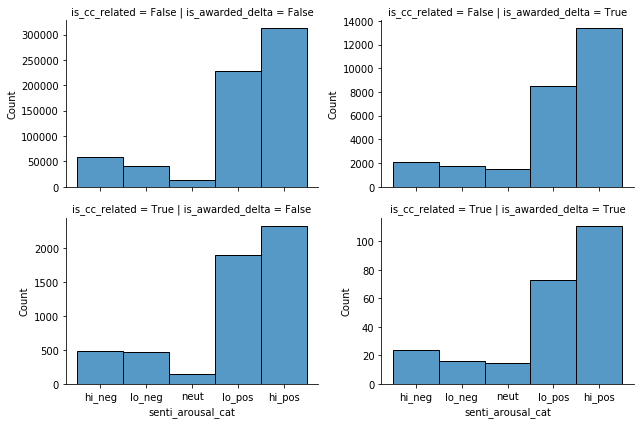

In [394]:
# Plot distribution of arousal categories for comments

to_plot_df = pd.DataFrame({
    'is_awarded_delta': [subsample.get_utterance(utt_id).meta['is_awarded_delta']
                        for utt_id in utt_ids_to_keep],
    'senti_arousal_cat': [subsample.get_utterance(utt_id).meta['senti_arousal_cat']
                        for utt_id in utt_ids_to_keep],
    'is_cc_related': [subsample.get_utterance(utt_id).meta['is_cc_related']
                        for utt_id in utt_ids_to_keep]
    
})
to_plot_df['senti_arousal_cat'] = pd.Categorical(to_plot_df['senti_arousal_cat'], 
                                                 ['hi_neg','lo_neg','neut','lo_pos','hi_pos'])

g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", sharey=False, aspect=1.5)
g.map(sns.histplot, "senti_arousal_cat")

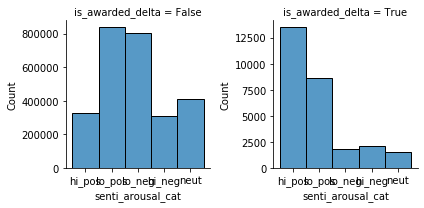

In [312]:
to_plot_df = pd.DataFrame({
    'is_awarded_delta': [corpus.get_utterance(utt_id).meta['is_awarded_delta']
                        for utt_id in utt_ids_to_keep],
    'senti_arousal_cat': [corpus.get_utterance(utt_id).meta['senti_arousal_cat']
                        for utt_id in utt_ids_to_keep]
})

g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False)
g.map(sns.histplot, "senti_arousal_cat")

# sns.displot(data=to_plot_df,
#                x='senti_arousal_cat',
#              hue='is_awarded_delta')

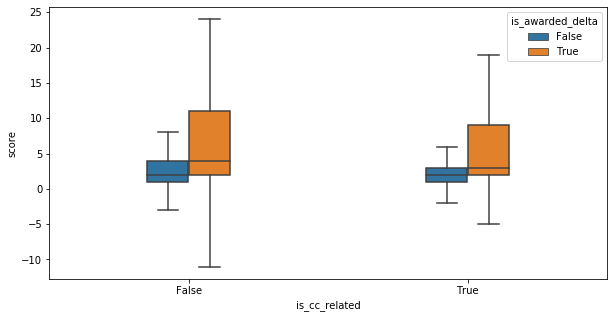

In [373]:
# Is score of a comment related to whether or not it gets a delta?
to_plot_df = pd.DataFrame({
    'is_awarded_delta': [subsample.get_utterance(utt_id).meta['is_awarded_delta']
                        for utt_id in utt_ids_to_keep],
    'score': [subsample.get_utterance(utt_id).meta['score']
                        for utt_id in utt_ids_to_keep],
    'is_cc_related': [subsample.get_utterance(utt_id).meta['is_cc_related']
                        for utt_id in utt_ids_to_keep]
})

sns.boxplot(data=to_plot_df, x='is_cc_related', y='score', showfliers=False, width=0.3,
           hue='is_awarded_delta')

### General LOR

In [172]:
fw_all = FightingWords()
fw_no_bots = FightingWords()
fw_no_generic_utts = FightingWords()

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
Initializing default CountVectorizer with ngram_range (1, 3)... Done.
Initializing default CountVectorizer with ngram_range (1, 3)... Done.


In [177]:
successful_utt_ids = [utt.id for utt in corpus.iter_utterances()
                     if utt.meta['is_cc_related'] 
                      and utt.meta['is_awarded_delta']]
len(successful_utt_ids)

316

In [178]:
pd.DataFrame({
    'id':successful_utt_ids,
    'text':[corpus.get_utterance(i).text 
           for i in successful_utt_ids]
})

,id,text
0,t1_fai041n,"Her goal is *not* to change the minds of people that disagree with climate change. \n\nFor the most part, that's impossible.\n\nHer goal is to galvanize the people that *agree* with the scientific consensus to organize and fight for action. \n\nWho cares what skeptics and deniers think? They're wrong and they will continue to be wrong. What matters is how hard the majority that believes in science will fight. \n\nI would argue that she's been very effective at that."
1,t1_cfs92i3,"But what if we're not far from a clean coal technology that is better than, say, burning oil or natural gas? Or what if people just use power from oil-burning factories instead? Whatever they use, as population and wealth grows, people will want to consume more energy, so even if the source is a bit cleaner than coal currently is, this can still be a problem. Also, there are some good reasons to think that [reducing consumption of meat](http://www.pbjcampaign.org/) is the most effective way to reduce climate-change-inducing pollution.\n\nThe point being, simply shutting down coal plants may be a good way to cut pollution, but it's not the best way. The best way would be to simply tax pollutants. This creates incentive for energy producers to find cleaner and more efficient ways to produce energy, regardless of whatever the method will be (and we can't predict ahead of time what those methods will be!). And it allows consumers to adjust their energy consumption in the way they each find least burdensome given each person's unique preferences, rather than forcing one way on everyone. [This NYTimes article](http://www.nytimes.com/2013/09/01/business/a-carbon-tax-that-america-could-live-with.html) elaborates further."
2,t1_f99227z,"So i think the reason many people think that socialism will help with climate change is the follows:\n\nSocialist lefties are pro climate activism, they view the industrial complex as the main source of pollution, and if they come to power, and have majority, enough to take over the means of production from individuals, they will have the power to stop the industrial complex from polluting for personal gain."
3,t1_f83z8zi,"There should be some burden, but it doesn't have to be huge. Anyone can shell out a few bucks for some reusable coffee cups. We can all benefit from eating less meat products. It's not a huge inconvenience for us to choose a shared Uber or public transportation. \n\nIf we all take a few small steps, it'll add up."
4,t1_ha1wfoj,You're demanding an experiment for what exactly? This is a question of multiple experiments.\n\nCan we experimentally prove that CO2 concentrations in the atmosphere insulate more solar radiation? Yes. \n\nCan we prove that more insulated solar radiation increase temperatures? Yes.\n\nCan we prove humanity releases inordinate amounts of CO2? Yes.\n\nWhich of these are you saying haven't been proven experimentally?
...,...,...
311,t1_du6w5dd,"I'm a climate scientist. I've worked on the National Climate Assessment and I do a ton of outreach to groups to explain the science to them. I'll do my best.\n\n> Please don’t resort to logical fallacies such as 97% of scientists confirm this(appeal to authority) or what not.\n\nI agree, that proves nothing about the science, but it does rebut a claim we often hear that ""the science isn't settled"" like it's some major point of contention within climate science. It's not. \n\n> Our models still give us only partially accurate short term weather predictions and climate change takes decades and has more unpredictable variables than weather.\n\nPredicting the weather and predicting the climate are entirely different beasts. Short-term prediction is about sorting through that chaos and saying ""This is how Thursday is gonna be."" Climate isn't actually that affected by chaos, because we're talking about long-term statistics, and all of that noise is filtered out. We're not saying ""The high temperature in NYC on October 12, 2048

In [173]:
fw_all.fit(corpus, 
        class1_func = lambda utt: (utt.meta['is_awarded_delta'] == 1)\
           and (utt.meta['is_cc_related']),
       class2_func = lambda utt: (utt.meta['is_awarded_delta'] == 0)\
          and (utt.meta['is_cc_related']))

class1_func returned 316 valid corpus components. class2_func returned 24798 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


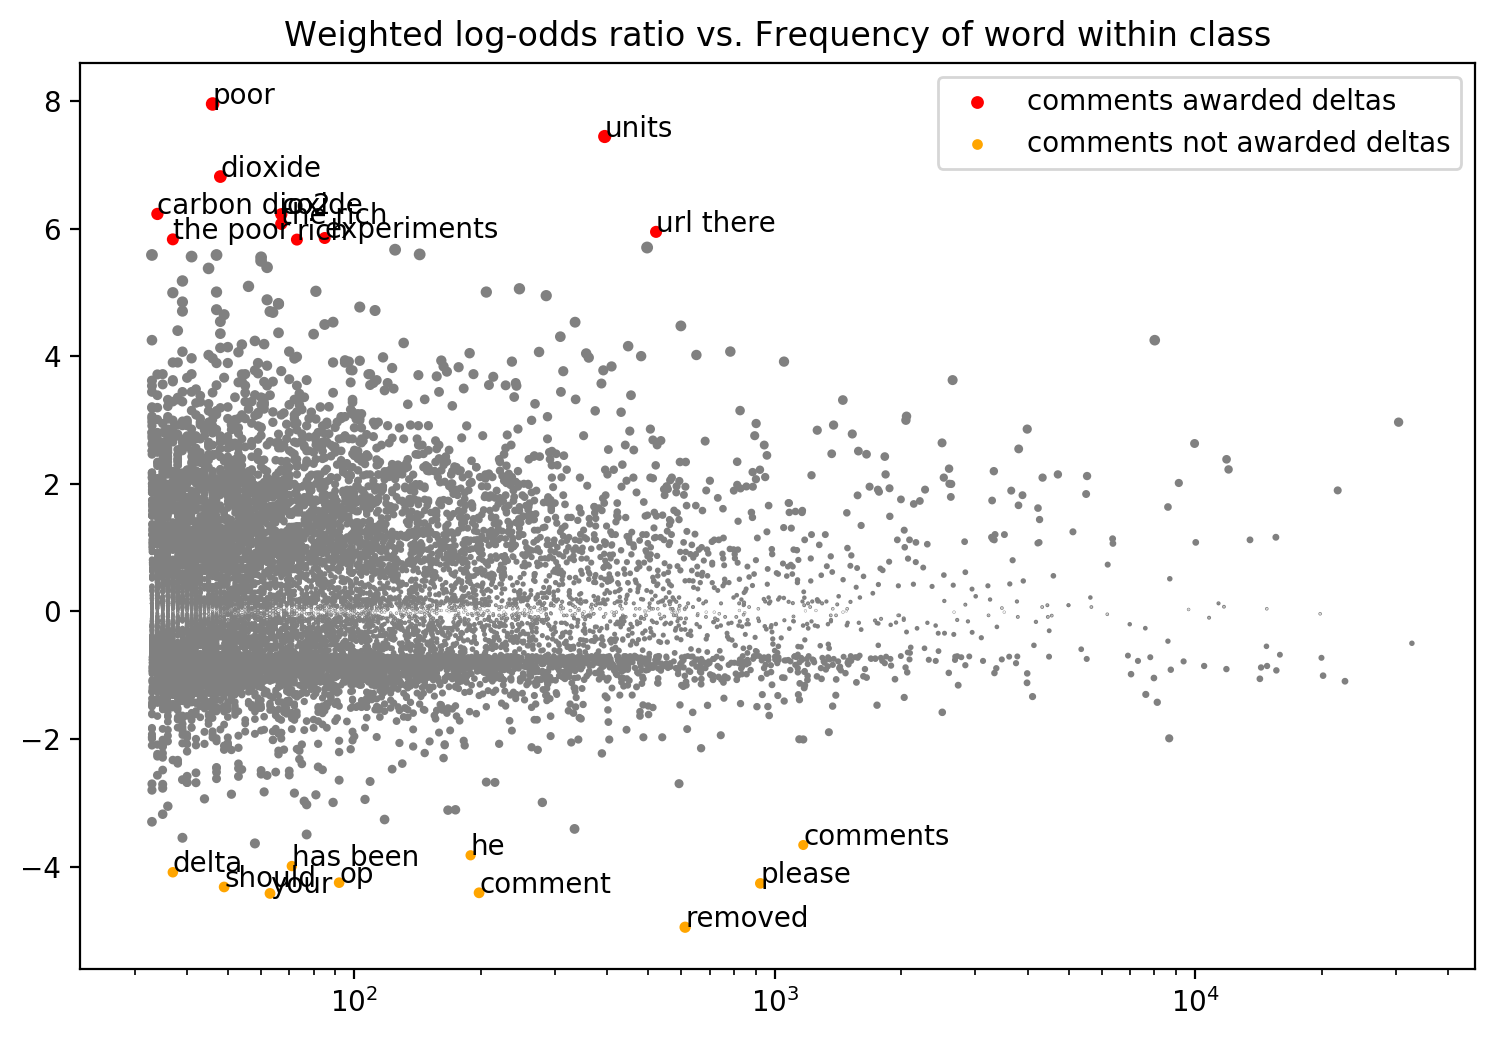

In [174]:
df_all = fw_all.summarize(corpus, plot=True, 
                  class1_name='comments awarded deltas', 
                    class2_name='comments not awarded deltas')

In [175]:
df_all.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
poor,7.952880,comments awarded deltas
units,7.442983,comments awarded deltas
dioxide,6.815170,comments awarded deltas
carbon dioxide,6.229400,comments awarded deltas
co2,6.224359,comments awarded deltas
the rich,6.074059,comments awarded deltas
url there,5.948274,comments awarded deltas
experiments,5.852355,comments awarded deltas
the poor,5.830947,comments awarded deltas


In [36]:
df_all.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
url,8.159434,comments awarded deltas
price,5.007118,comments awarded deltas
wiki,4.684719,comments awarded deltas
carbon taxes,4.506498,comments awarded deltas
the us,4.387404,comments awarded deltas
taxes,4.353331,comments awarded deltas
delta,4.014703,comments awarded deltas
christian,3.990494,comments awarded deltas
cur,3.974307,comments awarded deltas


In [26]:
fw_no_bots.fit(corpus, 
    class1_func = lambda utt: (not utt.meta['written_by_bot']) and (utt.meta['is_awarded_delta'] == 1)\
        and (utt.meta['is_cc_related']),
    class2_func = lambda utt: (not utt.meta['written_by_bot']) and (utt.meta['is_awarded_delta'] == 0)\
        and (utt.meta['is_cc_related']))

class1_func returned 7948 valid corpus components. class2_func returned 16686 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


In [35]:
# df_no_bots = fw_no_bots.summarize(corpus, plot=True, 
#                   class1_name='comments awarded deltas', class2_name='comments not awarded deltas')

In [28]:
df_no_bots.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
your comment,14.506357,comments awarded deltas
rule,13.996509,comments awarded deltas
clicking,13.927992,comments awarded deltas
by clicking,13.894580,comments awarded deltas
has been removed,13.771117,comments awarded deltas
clicking this link,13.562254,comments awarded deltas
clicking this,13.562254,comments awarded deltas
the moderators by,13.562254,comments awarded deltas
by clicking this,13.562254,comments awarded deltas


In [36]:
# fw_no_generic_utts.fit(corpus, 
#     class1_func = lambda utt: (~utt.meta['is_generic']) and (utt.meta['is_awarded_delta'] == 1)\
#         and (utt.meta['is_cc_related']),
#     class2_func = lambda utt: (~utt.meta['is_generic']) and (utt.meta['is_awarded_delta'] == 0)\
#         and (utt.meta['is_cc_related']))

In [37]:
# df_no_generic = fw_no_generic_utts.summarize(corpus, plot=True, 
#                   class1_name='comments awarded deltas', class2_name='comments not awarded deltas')

In [32]:
df_no_generic.sort_values('z-score',ascending=False).head(20)

,z-score,class
ngram,,
delta,25.117795,comments awarded deltas
explained,20.970349,comments awarded deltas
wiki,20.947304,comments awarded deltas
comments,18.189741,comments awarded deltas
url,17.828676,comments awarded deltas
awarded,16.926767,comments awarded deltas
user,15.951246,comments awarded deltas
your comment,15.176900,comments awarded deltas
note that,15.157092,comments awarded deltas


In [ ]:
# TO DO: better recall in filtering out generic comments

# TO DO: filter by stance

### LOR: high vs. low affect words

In [ ]:
# plot LOR but single out (high) affect-related words


### LOR: words from specific lexicons

In [19]:
# plot LOR but single out words from specific lexicons
PATH_TO_EMOLEX = "/u/scr/yiweil/datasets/NRC-Emotion-Intensity-Lexicon-v1.txt"
EMOLEX = pd.read_csv(PATH_TO_EMOLEX,sep='\t')

In [34]:
EMOLEX.head()

,word,emotion,emotion-intensity-score
0,outraged,anger,0.964
1,brutality,anger,0.959
2,hatred,anger,0.953
3,hateful,anger,0.940
4,terrorize,anger,0.939


In [150]:
EMOLEX[
    'emotion'
].value_counts()

fear            1765
trust           1564
anger           1483
sadness         1298
joy             1268
disgust         1094
anticipation     864
surprise         585
Name: emotion, dtype: int64

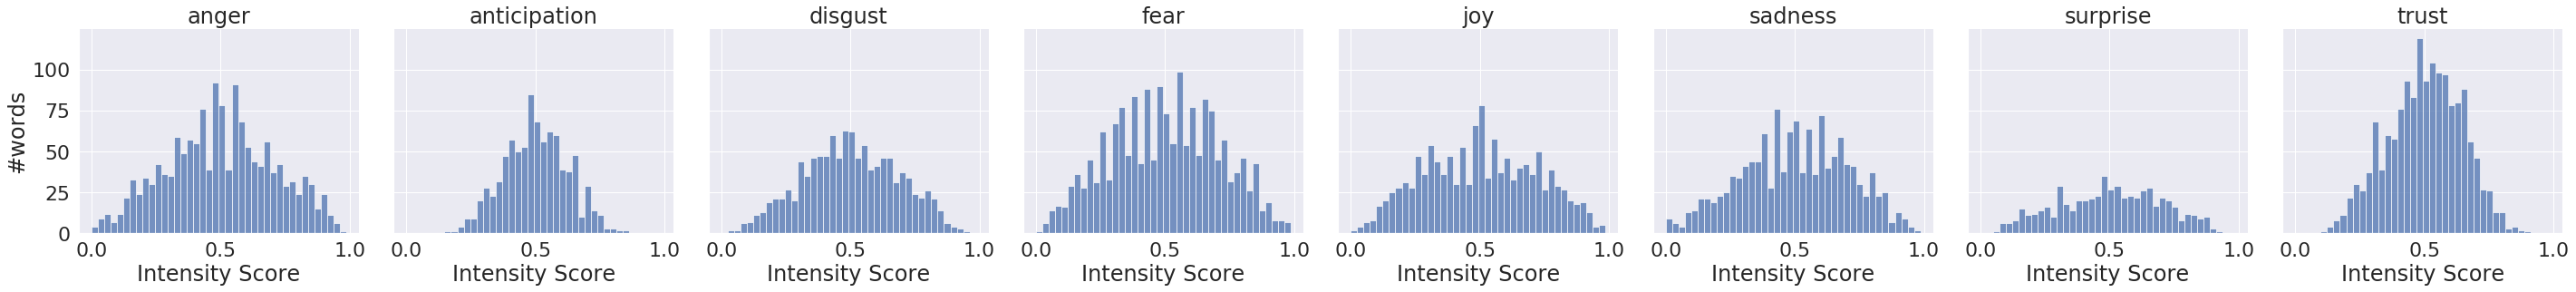

In [28]:
# Plot intensity scores for each emotion category
sns.set(font_scale=2)

g = sns.displot(data=EMOLEX,x='emotion-intensity-score',col='emotion')
g.set_titles("{col_name}")
g.set_axis_labels("Intensity Score", "#words")
if not os.path.exists('figs/'):
    os.mkdir('figs/')
g.savefig("figs/emolex_intensity_per_emotion.png")

In [47]:
# Distribution is pretty normal
# Let's threshold to 1.5 stds above the mean to obatin high intensity words in each category
per_emotion_means = EMOLEX.groupby('emotion').mean()
per_emotion_stds = EMOLEX.groupby('emotion').std()

EMOLEX['is_high_intensity'] = EMOLEX.apply(
    lambda x: x['emotion-intensity-score'] >= per_emotion_means['emotion-intensity-score'][x['emotion']], axis=1
)

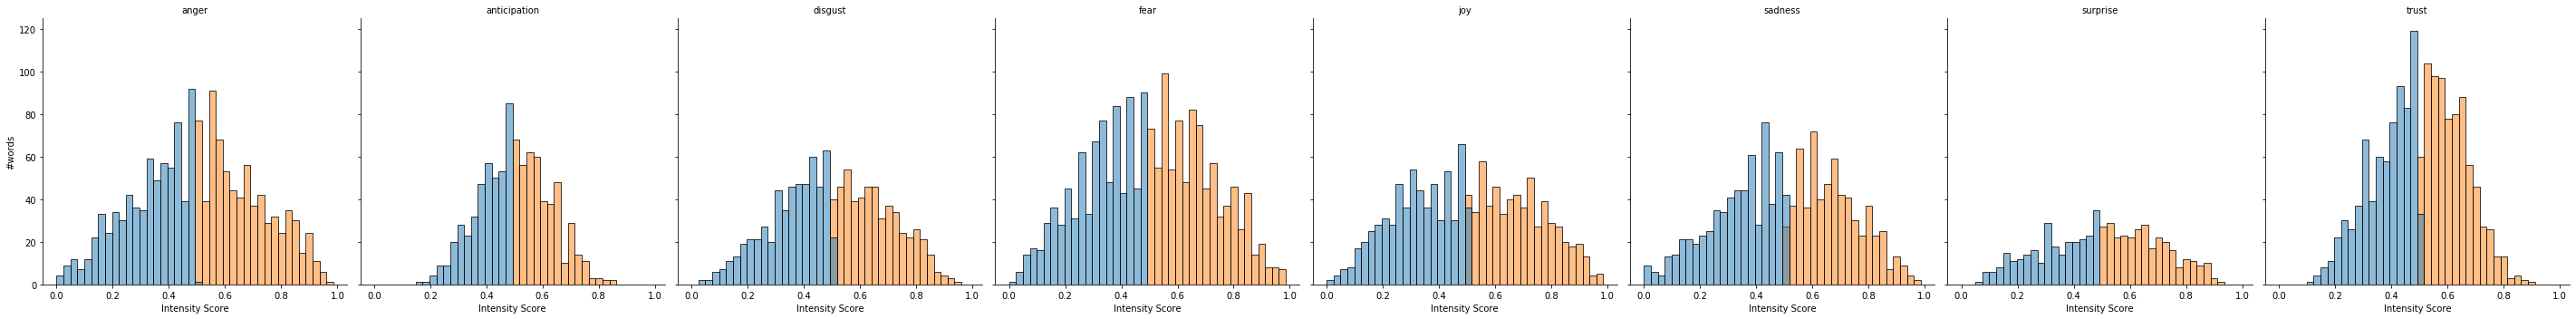

In [48]:
g = sns.displot(data=EMOLEX,x='emotion-intensity-score',hue='is_high_intensity',col='emotion')
g.set_titles("{col_name}")
g.set_axis_labels("Intensity Score", "#words")
g._legend.remove()

if not os.path.exists('figs/'):
    os.mkdir('figs/')
g.savefig("figs/emolex_intensity_per_emotion.png")

In [31]:
EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
          (EMOLEX['emotion']=='joy')]['word'].values

array(['happiest', 'happiness', 'bliss', 'celebrating', 'jubilant',
       'ecstatic', 'elation', 'beaming', 'bestdayever', 'loveee',
       'celebration', 'awesomeness', 'joy', 'excitement', 'joyous',
       'happily', 'exuberance', 'makesmehappy', 'euphoria', 'fabulous',
       'lovee', 'gratitude', 'merriment', 'spectacular', 'happydance',
       'purebliss', 'overjoyed', 'triumphant', 'cheerful', 'lovelovelove',
       'ecstasy', 'cheer', 'elated', 'delighted', 'exhilaration',
       'peaceofmind', 'jolly', 'lovethis', 'excitation', 'pleasures',
       'laugh', 'marvelously', 'loving', 'blissful', 'joyful',
       'outstanding', 'pleasurable', 'yaaaay', 'happyplace',
       'overthemoon', 'glee', 'enthusiastic', 'lovinglife', 'iloveher',
       'sohappy', 'laughing', 'superb', 'woohoo', 'wonderful',
       'ilovechristmas', 'cheering', 'magnificent', 'celebrated',
       'hooray', 'loved', 'brilliant', 'hallelujah', 'tearsofjoy',
       'yayyyy', 'glory', 'heavenly', 'exciting', 't

In [49]:
#import importlib
os.chdir('../1_data_collection/reddit/convokit')
#import customized_fighting_words
import importlib
importlib.reload(customized_fighting_words)
from customized_fighting_words import FightingWords
os.chdir(og_dir)

In [50]:
fw_all = FightingWords()
fw_all.fit(corpus, class1_func = lambda utt: (utt.meta['is_awarded_delta'] == 1)\
           and (utt.meta['is_cc_related']),
       class2_func = lambda utt: (utt.meta['is_awarded_delta'] == 0)\
          and (utt.meta['is_cc_related']))

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 8414 valid corpus components. class2_func returned 16700 valid corpus components.
Vocab size is 15000
Comparing language...
ngram zscores computed.


In [ ]:
# Distribution of z-scores for high and low intensity words
sns.displot(data=df_all,x=)

In [285]:
# # no annotations of words or non-of-interest words--too crowded
# fw_all.plot_fighting_words_fancy(class1_name='high intensity emotion words', 
#                                  class2_name='low intensity emotion words', 
#                                  config={'threshold': 1.96, 'annot_method': 'custom'},
#                                 word_set1=set(EMOLEX.loc[(EMOLEX['is_high_intensity'])]['word'].values),
#                                 word_set2=set(EMOLEX.loc[~EMOLEX['is_high_intensity']]['word'].values),
#                                 verbose=True)

In [284]:
# fw_all.plot_fighting_words_fancy(class1_name='high intensity emotion words', 
#                                  class2_name='low intensity emotion words', 
#                                  config={'threshold': 1.96, 'annot_method': 'custom'},
#                                 word_set1=set(EMOLEX.loc[(EMOLEX['is_high_intensity'])]['word'].values),
#                                 word_set2=set(EMOLEX.loc[~EMOLEX['is_high_intensity']]['word'].values),
#                                 verbose=True)

In [283]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='joy')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [282]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='anger')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [281]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='disgust')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [280]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='fear')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [279]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='sadness')]['word'].values))].sort_values('z-score',ascending=False).head(20)

In [278]:
# df_all.loc[df_all.index.isin(set(EMOLEX.loc[(EMOLEX['is_high_intensity']) & 
#           (EMOLEX['emotion']=='surprise')]['word'].values))].sort_values('z-score',ascending=False).head(20)

# Hypothesis: engaging with opponent is good strategy (agree > disagree chains)

Already tested in other paper and found to be ineffective.

# Topic analysis

## Why do "doom people" think we're doomed?